# Communication-Efficient Distributed SGD using Preamble-based Random Access by Choi Available at https://arxiv.org/abs/2105.09427

## Imports

In [339]:
# Import needed libraries
import numpy as np # arrays
import matplotlib.pyplot as plt #ploting
import scipy.optimize as sciopt    # linprog
from scipy.optimize import nnls # NNLS SOLVER

## Auxiliary functions

Construct the codebook as a scaled cross polytope:
$$ \cal{C}_{cp} = \{ \pm \textrm{R}e_l : \{1,...,\textrm{L}\}\} $$
with $ R = \sqrt{L} $, with $L$ being the block length.

In [340]:
def construct_codebook(blockLength):
    '''
    The construct_codebook method implements construction of the codebook as a scaled cross polytope.

    '''
    # Construct the codebook as a scaled cross polytope
    R = np.sqrt(blockLength)
    # EQUATION (14)
    codebook = np.concatenate(((np.eye(blockLength)*R),(np.eye(blockLength)*(-R))),axis=0) + 0 # add zero to fix -0.0 issue
    return codebook

In [341]:
def quantize(codebook,numBlocks,blockLength,gradient,Vmax):
    '''
    The quantize method implements the Subvector splitting alongside the Vector quantization using Convex Combination

    '''
    prob = np.zeros(numBlocks)
    norms = np.zeros(numBlocks)
    c_idx = np.zeros(numBlocks, int)

    for block in range(numBlocks):

        # defines beginning and end of the subvectors
        begin = block*blockLength
        end = block*blockLength+blockLength

        #gets the subvector from the gradient
        v_d = gradient[begin:end]
        norms[block] = np.linalg.norm(v_d)
        v_til = (v_d)/norms[block]

        # if the norm is not Vmax then update v_d and its part inside the gradient vector 
        if(norms[block] > Vmax):
            v_d = v_d*(Vmax/norms[block])
            norms[block] = Vmax
            gradient[begin:end] = v_d
            v_til = (v_d)/norms[block]

        # solving the linear system
        M = codebook.shape[0]
        A = np.concatenate((codebook.T,np.ones((1,M))),axis=0)
        b = np.concatenate((v_til,np.ones(1)),axis=0)


        a_vec = nnls(A, b)[0] # Using Non-negative Least Squares
        ## scipy.optimize.nnls solves the KKT (Karush-Kuhn-Tucker) conditions for the non-negative least squares problem.

        # EQUATION (8)
        c_idx[block] = np.random.choice(M, p=a_vec) # use a_vec as probabilities for choosing the codeword

        prob[block] = norms[block]/Vmax # probability of transmitting the codeword

    return prob, norms, c_idx, gradient # returns the norms and the indexs of the codewords and the updated gradient

In [342]:
def quantize_vqSGD(codebook,numBlocks,blockLength,gradient,Vmax):
    '''
    The quantize method implements the Subvector splitting alongside the Vector quantization from vqSGD: Vector Quantized Stochastic Gradient Descent (https://arxiv.org/pdf/1911.07971.pdf)
    EQUATION (4)
    '''
    prob = np.zeros(numBlocks)
    norms = np.zeros(numBlocks)
    c_idx = np.zeros(numBlocks, int)
    M = codebook.shape[0]
    R=np.sqrt(blockLength)

    for block in range(numBlocks):
        
        # defines beginning and end of the subvectors
        begin = block*blockLength
        end = block*blockLength+blockLength

        #gets the subvector from the gradient
        v_d = gradient[begin:end]
        norms[block] = np.linalg.norm(v_d)
        v_til = (v_d)/norms[block]

        # if the norm is not Vmax then update v_d and its part inside the gradient vector 
        if(norms[block] > Vmax):
            v_d = v_d*(Vmax/norms[block])
            norms[block] = Vmax
            gradient[begin:end] = v_d
            v_til = (v_d)/norms[block]

        # EQUATION (4) from vqSGD:
        const = (1 - np.sum(np.abs(v_til))/R)/(2*blockLength)
        a_vec_part1 = np.zeros(blockLength)
        a_vec_part2 = np.zeros(blockLength)
        
        for i,vi in enumerate(v_til):
            if vi >= 0:
                a_vec_part1[i] = vi/R+const
                a_vec_part2[i] = const
            else:
                a_vec_part1[i] = const
                a_vec_part2[i] = (-1)*(vi/R)+const
        
        a_vec = np.concatenate((a_vec_part1,a_vec_part2),axis=0)

        # EQUATION (8) from Choi's paper

        c_idx[block] = np.random.choice(M, p=a_vec) # use a_vec as probabilities for choosing the codeword

        prob[block] = norms[block]/Vmax # probability of transmitting the codeword

    return prob, norms, c_idx, gradient # returns the norms and the indexs of the codewords and the updated gradient

In [343]:
def RA_mix(prob, qidx, codebook,blockLength, numBlocks,N,P,snr):
    '''
    RA mix implements the scenario presented in section V-B. Noncoherent Combining with Multiple Antennas

    '''
    
    M = codebook.shape[0]
    K = prob.shape[0]
    grad = np.zeros(L)
    N0 = P/snr
    
    
    # for each block find which devices is transmitting its subvector (i.e. b[k] = 1)
    for block in range(numBlocks):

        bk = np.zeros(K)
        for k in range(K):
            if np.random.uniform() < probs[k,block]:
                bk[k] = 1

        a = np.zeros(blockLength)
        
        # for each codeword m calculate the output of the correlator zm:
        # EQUATION (39)
        for m in range(M):
            Id = np.eye(N)
            SigmaM = (np.sum(bk[(qidx[:,block]==m)])+np.sqrt(N0))*Id
            z = (np.random.multivariate_normal(mean=np.zeros(N),cov=SigmaM)+np.random.multivariate_normal(mean=np.zeros(N),cov=SigmaM)*(1j))/np.sqrt(2)
            z_m2 = (np.linalg.norm(z)**2)/N
            # EQUATION (42)
            a += z_m2*codebook[m]/K
        
        # defines beginning and end of the subvzectors
        begin = block*blockLength
        end = block*blockLength+blockLength
        
        # updates the slice of the gradient for each block
        # EQUATION (45)
        grad[begin:end] = a*(Vmax/P)
    
    return grad

In [344]:
def RA_mix_Choi(prob, qidx, codebook,blockLength, numBlocks,N,P,snr):
    '''
    RA mix implements the scenario presented in section V-B. Noncoherent Combining with Multiple Antennas (CHOI VERSION)

    '''
    
    M = codebook.shape[0]
    K = prob.shape[0]
    grad = np.zeros(L)
    N0 = P/snr
    disp_ids = np.arange(0,K,1)
    H = np.sqrt(0.5)*(np.random.randn(K,N)+np.random.randn(K,N)*(1j)) # channel h_k
     
    # for each block find which devices is transmitting its subvector (i.e. b[k] = 1)
    for block in range(numBlocks):

        bk = np.zeros(K)
        for k in range(K):
            if np.random.uniform() < probs[k,block]:
                bk[k] = 1

        a = np.zeros(blockLength)

        for m in range(M):
            transmitting_devices = disp_ids[(bk==1) & (qidx[:,block] == m)] # gets devices that transmitted this codeword in this block
            noise = (np.random.randn(1,N) + np.random.randn(1,N)*(1j))/np.sqrt(2*snr) # noise per preamble in every antenna
            z = noise
            for td in transmitting_devices:
                z += H[td,:] #adds the channel contribution
            z_m2 = (np.linalg.norm(z)**2)/N ## takes the average contribution from all antennas
            
            # EQUATION (42)
            a += z_m2*codebook[m]/K # sums the contribution of every codeword
            
            
        
        # defines beginning and end of the subvzectors
        begin = block*blockLength
        end = block*blockLength+blockLength
        
        # updates the slice of the gradient for each block
        # EQUATION (45)
        grad[begin:end] = a*(Vmax/P)
    
    return grad

In [345]:
def quick_mix(prob, qidx, codebook,blockLength, numBlocks,N,P,snr,norms):
    '''
    Quick mix implements the scenario where the BS knows the codeword and the norm transmitted by each device.
    Equation (20)
    '''
    
    
    M = codebook.shape[0]
    K = prob.shape[0]
    grad = np.zeros(L)
    noise = P/snr
        
    for block in range(numBlocks):

        v_til = np.zeros(codebook.shape[1])
        
        for m in range(M):
            idxs = np.where(qidx[:,block]==m)[0]
            norm_km = norms[idxs,block]

            for n in norm_km:
                v_til += n*codebook[m]

        begin = block*blockLength
        end = block*blockLength+blockLength

        grad[begin:end] = v_til/K
    
    return grad

## Definitions

In [346]:
# Definitions
K = 500 # Number of datasets distributed over K devices (i.e., 1 data set per device)
numBlocks = 10  # amount of blocks in a gradient vector (D subvectors)
blockLength = 8 # block length
bK = 5 # miniBatch size for YANG method
L = blockLength*numBlocks # Lenght of w
u =  0.01 # step size or learning rate
T = 100 # Number of iterations
Vmax = np.sqrt(blockLength)*1.5 # "hardcoded" max vector norm (Choi's choice)
snr_db = 4 # signal to noise ratio dB
snr = 10**(np.log10(snr_db/10)) # linear snr
P = 1 # Assumed that sqrt(P_k)*h_k = P for all k devices
N_0 = P/snr # noise power
N = 100 # Number of antennas

## Performance varying the minibatch size

In [347]:
%%time
codebook = construct_codebook(blockLength)
miniBatches = np.arange(5, 55, 5)

mse_raus = np.zeros((2,len(miniBatches))) # 0 sim, 1 theo
mse_yang = np.zeros((2,len(miniBatches))) # 0 sim, 1 theo

mcr=10

for i,bK in enumerate(miniBatches):
    Rmse = np.zeros((2,mcr))
    Ymse = np.zeros((2,mcr))
    
    for mx in range(mcr):
        true_g = np.zeros(L)
        est_g = np.zeros(L)
        gradients = np.random.normal(size = (K,L))
        probs = np.zeros((K,numBlocks))
        qidx = np.zeros((K,numBlocks),int)
        norms_v = np.zeros((K,numBlocks))


        ### RAUS METHOD ###
        for k in range(K):
            probs[k,:], norms_v[k,:], qidx[k,:], gradients[k,:] = quantize_vqSGD(codebook,numBlocks,blockLength,gradients[k,:],Vmax)
            
        est_g = np.reshape(RA_mix(probs, qidx, codebook,blockLength, numBlocks,N,P,snr),(L,1)) # get estimated gradient
        true_g = np.reshape(np.mean(gradients,axis = 0),(L,1)) # true gradient from the updated gradients after subvectors are updated inside the quantization method
        Rmse[0,mx] =  np.sum(np.abs(true_g-est_g)**2) # RAUS MSE simulated
        Rmse[1,mx] = (np.sum(np.sum(np.abs(blockLength*Vmax - norms_v)*norms_v))/(K**2)) # RAUS MSE theoretical
        ### ---------- ###

        ### YANG METHOD ###
        RK = np.random.permutation(K)
        cK = RK[0:bK]
        ev = np.reshape(np.mean(gradients[cK,:].T,axis=1),(L,1))
        noise = np.random.randn(L,1)/np.sqrt(snr*N*bK)
        grad2 = ev + noise
        Ymse[0,mx] = np.sum(np.abs(true_g - grad2)**2) # YANG MSE simulated
        Ymse[1,mx] = 1/(bK*snr) + (np.sum(np.mean(norms_v**2,axis=0)) - np.linalg.norm(true_g)**2)/bK # YANG MSE theoretical
        ### ---------- ###
        
    mse_raus[0,i] = np.mean(Rmse[0,:])
    mse_raus[1,i] = np.mean(Rmse[1,:])
    mse_yang[0,i] = np.mean(Ymse[0,:])
    mse_yang[1,i] = np.mean(Ymse[1,:])

Wall time: 1min 25s


### Plotting

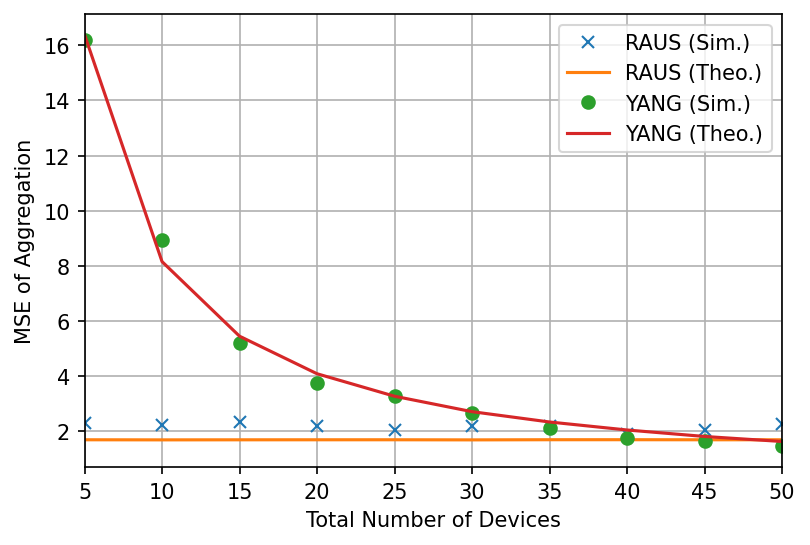

In [348]:
plt.figure(1, dpi = 150)
plt.xticks(miniBatches)
plt.xlim(5, 50)
plt.grid(True, which = 'both', ls='-')
plt.xlabel('Total Number of Devices')
plt.ylabel('MSE of Aggregation')
plt.plot(miniBatches,mse_raus[0,:],'x',label="RAUS (Sim.)",linewidth=2)
plt.plot(miniBatches,mse_raus[1,:],label="RAUS (Theo.)")
plt.plot(miniBatches,mse_yang[0,:],'o',label="YANG (Sim.)")
plt.plot(miniBatches,mse_yang[1,:],label="YANG (Theo.)")
plt.legend()
plt.show()

## Performance varying the total number of devices

In [243]:
%%time

codebook = construct_codebook(blockLength)
numOfDevices = np.arange(100, 1050, 50)

mse_raus = np.zeros((2,len(numOfDevices))) # 0 sim, 1 theo
mse_yang = np.zeros((2,len(numOfDevices))) # 0 sim, 1 theo
bK=10
mcr=10

for i,K in enumerate(numOfDevices):
    Rmse = np.zeros((2,mcr))
    Ymse = np.zeros((2,mcr))
    
    for mx in range(mcr):
        true_g = np.zeros(L)
        est_g = np.zeros(L)
        gradients = np.random.normal(size = (K,L))
        probs = np.zeros((K,numBlocks))
        qidx = np.zeros((K,numBlocks),int)
        norms_v = np.zeros((K,numBlocks))


        ### RAUS METHOD ###
        for k in range(K):
            probs[k,:], norms_v[k,:], qidx[k,:], gradients[k,:] = quantize(codebook,numBlocks,blockLength,gradients[k,:],Vmax)
            
        est_g = np.reshape(RA_mix(probs, qidx, codebook,blockLength, numBlocks,N,P,snr),(L,1))
        true_g = np.reshape(np.mean(gradients,axis = 0),(L,1))
        Rmse[0,mx] =  np.sum(np.abs(true_g-est_g)**2)
        Rmse[1,mx] = (np.sum(np.sum(np.abs(blockLength*Vmax - norms_v)*norms_v))/(K**2));
        ### ---------- ###

        ### YANG METHOD ###
        RK = np.random.permutation(K)
        cK = RK[0:bK]
        ev = np.reshape(np.mean(gradients[cK,:].T,axis=1),(L,1))
        noise = np.random.randn(L,1)/np.sqrt(snr*N*bK)
        grad2 = ev + noise
        Ymse[0,mx] = np.sum(np.abs(true_g - grad2)**2);
        Ymse[1,mx] = 1/(bK*snr) + (np.sum(np.mean(norms_v**2,axis=0)) - np.linalg.norm(true_g)**2)/bK;
        ### ---------- ###
        
    mse_raus[0,i] = np.mean(Rmse[0,:])
    mse_raus[1,i] = np.mean(Rmse[1,:])
    mse_yang[0,i] = np.mean(Ymse[0,:])
    mse_yang[1,i] = np.mean(Ymse[1,:])

Wall time: 1min 34s


#### Plotting

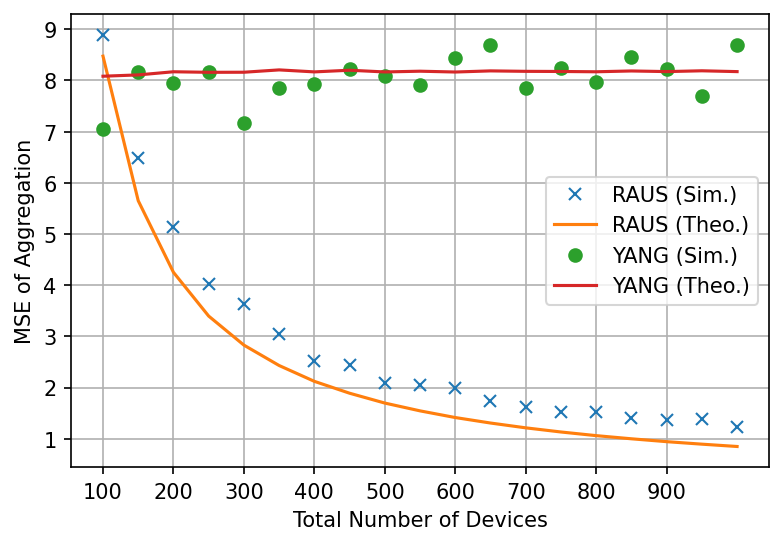

In [244]:
plt.figure(1, dpi = 150)
plt.xticks(np.arange(0,1000,100))
# plt.xlim(5, 50)
plt.grid(True, which = 'both', ls='-')
plt.xlabel('Total Number of Devices')
plt.ylabel('MSE of Aggregation')
plt.plot(numOfDevices,mse_raus[0,:],'x',label="RAUS (Sim.)",linewidth=2)
plt.plot(numOfDevices,mse_raus[1,:],label="RAUS (Theo.)")
plt.plot(numOfDevices,mse_yang[0,:],'o',label="YANG (Sim.)")
plt.plot(numOfDevices,mse_yang[1,:],label="YANG (Theo.)")
plt.legend()
plt.show()

## Performance of RAUS varying the length of the subvector

In [326]:
%%time

L = 4096
blockLength_arr = 2**np.arange(1,9,1)
numBlocks_arr = np.array(L/blockLength_arr,int)
mse_raus = np.zeros((2,len(blockLength_arr))) # 0 sim, 1 theo
mse_yang = np.zeros((2,len(blockLength_arr))) # 0 sim, 1 theo

K=100
bK=10
mcr=10

i = 0
for blockLength,numBlocks in zip(blockLength_arr,numBlocks_arr):
    
    Vmax = np.sqrt(blockLength)*1.5
    codebook = construct_codebook(blockLength)
    Rmse = np.zeros((2,mcr))
    Ymse = np.zeros((2,mcr))
    
    for mx in range(mcr):
        true_g = np.zeros(L)
        est_g = np.zeros(L)
        gradients = np.random.normal(size = (K,L))
        probs = np.zeros((K,numBlocks))
        qidx = np.zeros((K,numBlocks),int)
        norms_v = np.zeros((K,numBlocks))


        ### RAUS METHOD ###
        for k in range(K):
            probs[k,:], norms_v[k,:], qidx[k,:], gradients[k,:] = quantize(codebook,numBlocks,blockLength,gradients[k,:],Vmax)
            
        est_g = np.reshape(RA_mix(probs, qidx, codebook,blockLength, numBlocks,N,P,snr),(L,1))
        true_g = np.reshape(np.mean(gradients,axis = 0),(L,1))
        Rmse[0,mx] =  np.sum(np.abs(true_g-est_g)**2)
        Rmse[1,mx] = (np.sum(np.sum(np.abs(blockLength*Vmax - norms_v)*norms_v))/(K**2));
        ### ---------- ###

    mse_raus[0,i] = np.mean(Rmse[0,:])
    mse_raus[1,i] = np.mean(Rmse[1,:])

    i += 1

Wall time: 52min 38s


#### Plotting

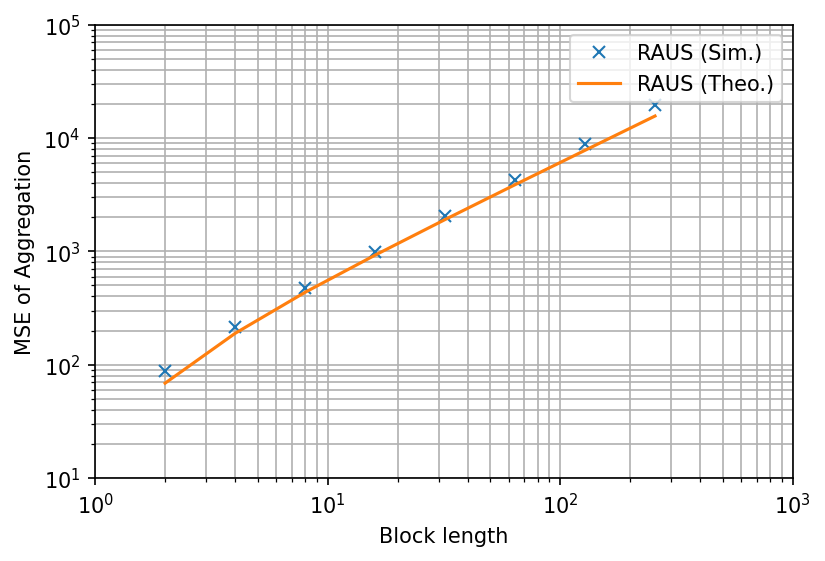

In [327]:
plt.figure(1, dpi = 150)
plt.xticks(blockLength_arr)
plt.xlim(1, 10**3)
plt.ylim(10,10**5)
plt.grid(True, which = 'both', ls='-')
plt.xlabel('Block length')
plt.ylabel('MSE of Aggregation')
plt.loglog(blockLength_arr,mse_raus[0,:],'x',label="RAUS (Sim.)",linewidth=2)
plt.loglog(blockLength_arr,mse_raus[1,:],label="RAUS (Theo.)")
plt.legend()
plt.show()

## Quick mix

In [15]:
# %%time
codebook = construct_codebook(blockLength)
miniBatches = np.arange(5, 55, 5)

mse_raus = np.zeros((2,len(miniBatches))) # 0 sim, 1 theo
mse_yang = np.zeros((2,len(miniBatches))) # 0 sim, 1 theo

mcr=10

for i,bK in enumerate(miniBatches):
    Rmse = np.zeros((2,mcr))
    Ymse = np.zeros((2,mcr))
    
    for mx in range(mcr):
        true_g = np.zeros(L)
        est_g = np.zeros(L)
        gradients = np.random.normal(size = (K,L))
        probs = np.zeros((K,numBlocks))
        qidx = np.zeros((K,numBlocks),int)
        norms_v = np.zeros((K,numBlocks))


        ### RAUS METHOD ###
        for k in range(K):
            probs[k,:], norms_v[k,:], qidx[k,:], gradients[k,:] = quantize(codebook,numBlocks,blockLength,gradients[k,:],Vmax)
            
        est_g = np.reshape(RA_mix(probs, qidx, codebook,blockLength, numBlocks,N,P,snr),(L,1))
        true_g = np.reshape(np.mean(gradients,axis = 0),(L,1))
        Rmse[0,mx] =  np.sum(np.abs(true_g-est_g)**2)
        Rmse[1,mx] = (np.sum(np.sum(np.abs(blockLength*Vmax - norms_v)*norms_v))/(K**2));
        ### ---------- ###

        ### YANG METHOD ###
        RK = np.random.permutation(K)
        cK = RK[0:bK]
        ev = np.reshape(np.mean(gradients[cK,:].T,axis=1),(L,1))
        noise = np.random.randn(L,1)/np.sqrt(snr*N*bK)
        grad2 = ev + noise
        Ymse[0,mx] = np.sum(np.abs(true_g - grad2)**2);
        Ymse[1,mx] = 1/(bK*snr) + (np.sum(np.mean(norms_v**2,axis=0)) - np.linalg.norm(true_g)**2)/bK;
        ### ---------- ###
        
    mse_raus[0,i] = np.mean(Rmse[0,:])
    mse_raus[1,i] = np.mean(Rmse[1,:])
    mse_yang[0,i] = np.mean(Ymse[0,:])
    mse_yang[1,i] = np.mean(Ymse[1,:])

#### Plotting

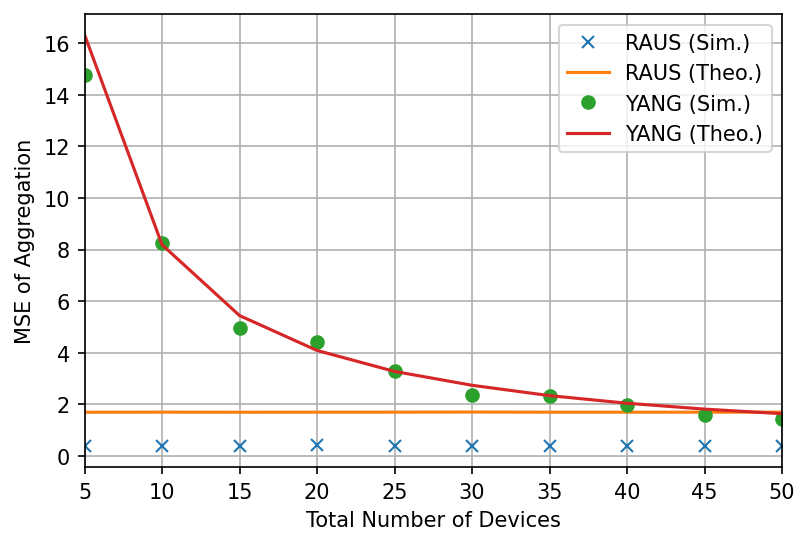

In [16]:
plt.figure(1, dpi = 150)
plt.xticks(miniBatches)
plt.xlim(5, 50)
plt.grid(True, which = 'both', ls='-')
plt.xlabel('Total Number of Devices')
plt.ylabel('MSE of Aggregation')
plt.plot(miniBatches,mse_raus[0,:],'x',label="RAUS (Sim.)",linewidth=2)
plt.plot(miniBatches,mse_raus[1,:],label="RAUS (Theo.)")
plt.plot(miniBatches,mse_yang[0,:],'o',label="YANG (Sim.)")
plt.plot(miniBatches,mse_yang[1,:],label="YANG (Theo.)")
plt.legend()
plt.show()